<a href="https://colab.research.google.com/github/FatmaBuseBorlu/Dramer-Dataset-LSTM/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [114]:
from IPython import get_ipython
from IPython.display import display

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torcheeg.datasets import DREAMERDataset
from torcheeg import transforms
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import kagglehub
import os
import kagglehub
import random
import shutil
from torcheeg.transforms import ToTensor, BaselineRemoval, MeanStdNormalize, To2d, RandomNoise
from torchvision.transforms import Compose

In [115]:
# Kaggle'dan veri setini indirin
path = kagglehub.dataset_download("phhasian0710/dreamer")
print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/phhasian0710/dreamer/versions/1


In [116]:
import os

# Veri seti yolunu kontrol edin
dataset_dir = "/root/.cache/kagglehub/datasets/phhasian0710/dreamer/versions/1"
mat_file_path = os.path.join(dataset_dir, "DREAMER.mat")

if os.path.exists(mat_file_path):
    print("DREAMER.mat dosyası bulundu!")
else:
    print("DREAMER.mat dosyası bulunamadı! Lütfen dosyanın doğru bir şekilde indirildiğinden emin olun.")


DREAMER.mat dosyası bulundu!


In [149]:
dataset = DREAMERDataset(
    mat_path='/root/.cache/kagglehub/datasets/phhasian0710/dreamer/versions/1/DREAMER.mat',
    io_path='./dreamer_rnn_data_safe1',
   offline_transform=transforms.Compose([
        transforms.BaselineRemoval(),
        transforms.MeanStdNormalize(),
        transforms.To2d(),
        transforms.ToTensor(),  # Numpy'den Tensöre çevirme
        transforms.RandomNoise(std=0.01),
        CustomRandomFlip(axis=2)
    ]),
    # Remove or modify online_transform
    #online_transform=transforms.ToTensor(),  # This line is causing the error
    online_transform=None, # No online transformation
    label_transform=transforms.Compose([
        transforms.Select('valence'),
        transforms.Binary(3.0)
    ]),
    chunk_size=128,
    baseline_chunk_size=128,
    num_baseline=61,
    num_worker=4
)

[2024-12-21 18:16:49] INFO (torcheeg/MainThread) 🔍 | Detected cached processing results, reading cache from ./dreamer_rnn_data_safe1.
INFO:torcheeg:🔍 | Detected cached processing results, reading cache from ./dreamer_rnn_data_safe1.


In [150]:
# Veri setini eğitim ve test olarak ayırın
data_size = len(dataset)
train_size = int(0.8 * data_size)
test_size = data_size - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Veri Yükleyicileri
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [151]:
# LSTM Model Tanımı
class EEG_LSTM_Model(nn.Module):
    def __init__(self, input_size=128, hidden_size=64, num_layers=2, num_classes=2):
        super(EEG_LSTM_Model, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.5)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.squeeze(1)  # Girdi boyutu: [batch_size, sequence_length, features]
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]  # Son zaman adımının çıktısını alın
        out = self.fc(out)
        return out

In [152]:
# Modeli, Kayıp Fonksiyonu ve Optimizasyon Tanımı
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EEG_LSTM_Model(input_size=128, hidden_size=64, num_layers=2, num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

In [153]:
# Eğitim Fonksiyonu
def train_one_epoch():
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.float().to(device), labels.long().to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)

In [154]:
# Test Fonksiyonu
def test_model():
    model.eval()
    running_loss, all_preds, all_labels = 0.0, [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.float().to(device), labels.long().to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    avg_loss = running_loss / len(test_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    return avg_loss, accuracy, all_labels, all_preds

In [155]:
# Model Eğitim Döngüsü
epochs, patience = 10, 3
best_loss, counter = float('inf'), 0
train_losses, test_losses, test_accs = [], [], []

for epoch in range(epochs):
    train_loss = train_one_epoch()
    test_loss, test_acc, _, _ = test_model()
    scheduler.step()

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    test_accs.append(test_acc)

    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")
    if test_loss < best_loss:
        best_loss, counter = test_loss, 0
        print("En iyi model kaydedildi!")
    else:
        counter += 1
    if counter >= patience:
        print("Early stopping tetiklendi!")
        break

[PROCESS]:  30%|███       | 7/23 [59:35<2:16:11, 510.71s/it]


Epoch 1: Train Loss: 0.6594, Test Loss: 0.6495, Test Acc: 0.6204
En iyi model kaydedildi!
Epoch 2: Train Loss: 0.6420, Test Loss: 0.6358, Test Acc: 0.6361
En iyi model kaydedildi!
Epoch 3: Train Loss: 0.6229, Test Loss: 0.6209, Test Acc: 0.6482
En iyi model kaydedildi!
Epoch 4: Train Loss: 0.6051, Test Loss: 0.6138, Test Acc: 0.6578
En iyi model kaydedildi!
Epoch 5: Train Loss: 0.5877, Test Loss: 0.5992, Test Acc: 0.6686
En iyi model kaydedildi!
Epoch 6: Train Loss: 0.5668, Test Loss: 0.5900, Test Acc: 0.6749
En iyi model kaydedildi!
Epoch 7: Train Loss: 0.5514, Test Loss: 0.5956, Test Acc: 0.6771
Epoch 8: Train Loss: 0.5366, Test Loss: 0.5899, Test Acc: 0.6784
En iyi model kaydedildi!
Epoch 9: Train Loss: 0.5275, Test Loss: 0.5932, Test Acc: 0.6788
Epoch 10: Train Loss: 0.5215, Test Loss: 0.5934, Test Acc: 0.6813


In [156]:
# Sonuçları tekrar test edip raporla
test_loss, test_acc, all_labels, all_preds = test_model()
print(f"Final Test Accuracy: {test_acc:.4f}")
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", classification_report(all_labels, all_preds))

Final Test Accuracy: 0.6813
Confusion Matrix:
 [[2848 3863]
 [1602 8836]]
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.42      0.51      6711
           1       0.70      0.85      0.76     10438

    accuracy                           0.68     17149
   macro avg       0.67      0.64      0.64     17149
weighted avg       0.67      0.68      0.66     17149



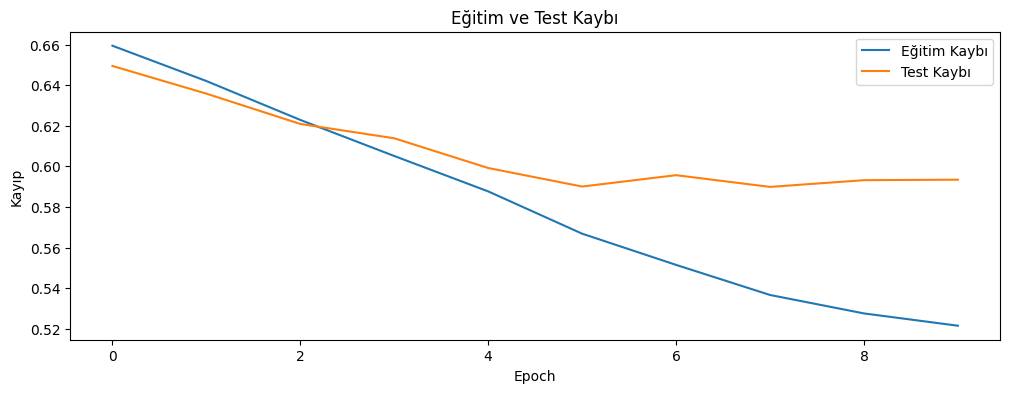

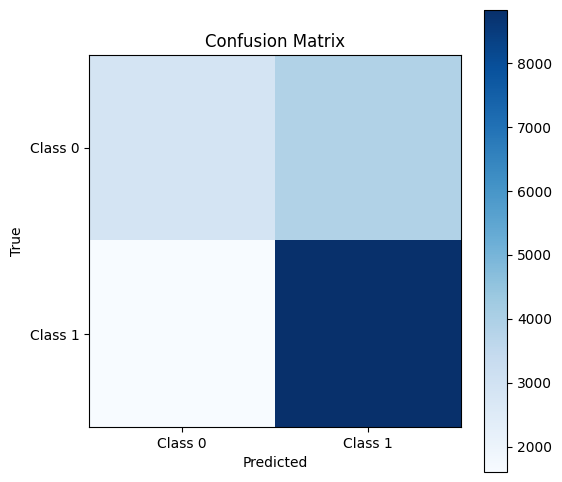

In [157]:
def plot_results(labels, preds, train_losses, test_losses):
    # Basitleştirilmiş grafik fonksiyonu
    plt.figure(figsize=(12, 4))
    plt.plot(train_losses, label='Eğitim Kaybı')
    plt.plot(test_losses, label='Test Kaybı')
    plt.title('Eğitim ve Test Kaybı')
    plt.xlabel('Epoch')
    plt.ylabel('Kayıp')
    plt.legend()
    plt.show()

    plt.figure(figsize=(6, 6))
    cm = confusion_matrix(labels, preds)
    plt.imshow(cm, cmap='Blues', interpolation='nearest')
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.xticks([0, 1], ['Class 0', 'Class 1'])
    plt.yticks([0, 1], ['Class 0', 'Class 1'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_results(all_labels, all_preds, train_losses, test_losses)